In [6]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.kernel_ridge import KernelRidge

# Load data
housing = fetch_california_housing()
X = housing.data
y = housing.target

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

In [15]:
X.shape, X_train.shape, X_test.shape

((20640, 8), (4128, 8), (16512, 8))

In [7]:
X_train.shape


(4128, 8)

In [51]:
X_train.max()

35682.0

In [8]:
# kernel ridge regression with optimized hyperparameters via random search
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from scipy.stats import expon

# define model
model = KernelRidge()

# define search space
param_grid = dict()
param_grid['alpha'] = uniform(loc=0, scale=1)
param_grid['gamma'] = expon(loc=0, scale=1)

# define search
search = RandomizedSearchCV(model, param_grid, n_iter=100, scoring='neg_mean_squared_error', n_jobs=-1, cv=5, random_state=42)

# execute search
result = search.fit(X_train, y_train)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)
print('Best Model: %s' % result.best_estimator_)

Best Score: -5.256277664830139
Best Hyperparameters: {'alpha': 0.005522117123602399, 'gamma': 1.689896777486126}
Best Model: KernelRidge(alpha=0.005522117123602399, gamma=1.689896777486126)


TRAINING SCORE AT START: 0.5298901432982209
TEST SCORE AT START: 0.5440174555637713
TRAINING MSE AT START: 0.6327619224992171
TEST MSE AT START: 0.6055163832768921


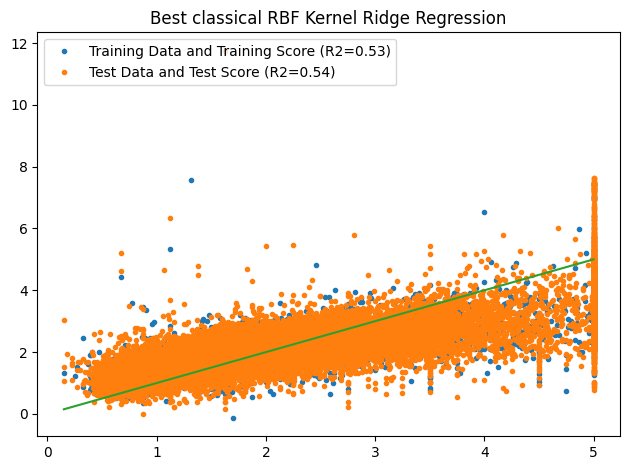

In [19]:
import matplotlib.pyplot as plt
import numpy as np
# perform best kernel ridge regression
krr = result.best_estimator_
Y1 = krr.predict(X_train)
Y2 = krr.predict(X_test)
training_score = krr.score(X_train,y_train)
test_score = krr.score(X_test,y_test)
print("TRAINING SCORE AT START:",training_score)
print("TEST SCORE AT START:",test_score)
print("TRAINING MSE AT START:",mean_squared_error(y_train,Y1))
print("TEST MSE AT START:",mean_squared_error(y_test,Y2))
plt.figure()
plt.title("Best classical RBF Kernel Ridge Regression")
plt.plot(y_train,Y1,'.', label=f"Training Data and Training Score (R2={training_score:.2f})")
plt.plot(y_test,Y2,'.', label=f"Test Data and Test Score (R2={test_score:.2f})")
plt.plot([np.min(y_test),np.max(y_test)],[np.min(y_test),np.max(y_test)])
plt.legend(loc="upper left")
plt.tight_layout()                                                                                                      


In [12]:
from squlearn.feature_map import QEKFeatureMap, ChebPQC, YZ_CX_FeatureMap, HZCRxCRyCRz
qek_map = QEKFeatureMap(num_qubits=8, num_features=8, num_layers=1)
yz_cx = YZ_CX_FeatureMap(num_qubits=8, num_features=8, num_layers=1)
hzcrx = HZCRxCRyCRz(num_qubits=8, num_features=8, num_layers=1)
cheb_pqc = ChebPQC(num_qubits=8, num_features=8, num_layers=1)
print('num parameters qek:', qek_map.num_parameters)
print('num parameters yz_cx:', yz_cx.num_parameters)
print('num parameters hzcrx:', hzcrx.num_parameters)
print('num parameters cheb_pqc:', cheb_pqc.num_parameters)



num parameters qek: 16
num parameters yz_cx: 16
num parameters hzcrx: 24
num parameters cheb_pqc: 32


In [13]:
from squlearn.kernel.matrix import ProjectedQuantumKernel, FidelityKernel
from squlearn.util import Executor
from squlearn.kernel.ml import QKRR, QSVR

TRAINING SCORE AT START: 0.9859856147725395
TEST SCORE AT START: 0.18077587672906648


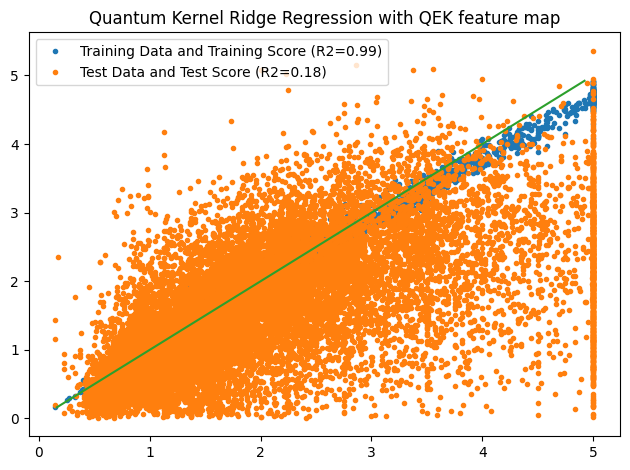

In [21]:
qek_kernel = ProjectedQuantumKernel(qek_map,Executor("statevector_simulator"),parameter_seed=0, gamma=1.6898)
qek_krr = QKRR(quantum_kernel=qek_kernel, alpha=0.1)
qek_krr.fit(X_train,y_train)

Y1_qek = qek_krr.predict(X_train)
Y2_qek = qek_krr.predict(X_test)

training_score_qek = qek_krr.score(X_train,y_train)
test_score_qek = qek_krr.score(X_test,y_test)
print("TRAINING SCORE AT START:",qek_krr.score(X_train,y_train))
print("TEST SCORE AT START:",qek_krr.score(X_test,y_test))
plt.figure()
plt.title("Quantum Kernel Ridge Regression with QEK feature map")
plt.plot(y_train,Y1_qek,'.', label=f"Training Data and Training Score (R2={training_score_qek:.2f})")
plt.plot(y_test,Y2_qek,'.', label=f"Test Data and Test Score (R2={test_score_qek:.2f})")
plt.plot([np.min(Y1_qek),np.max(Y1_qek)],[np.min(Y1_qek),np.max(Y1_qek)])
plt.legend(loc="upper left")
plt.tight_layout()


TRAINING SCORE AT START: 0.8993905585919996
TEST SCORE AT START: 0.5322329219054467


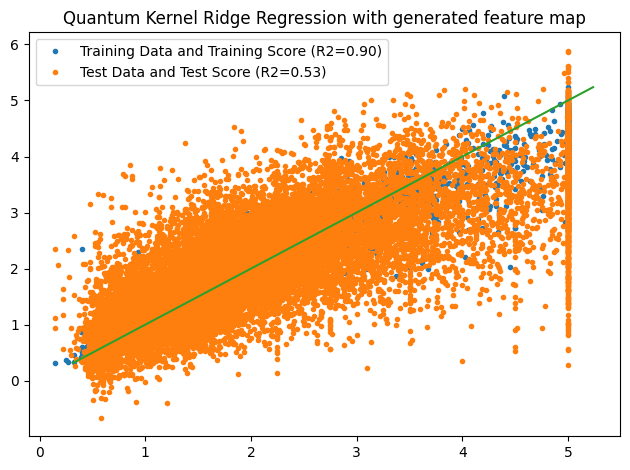

In [20]:
from squlearn.feature_map import LayeredFeatureMap
lfm = LayeredFeatureMap.from_string('Z--Rx(p,x;=y*(x),{y,x})-Z-Ry(p,x;=y*(x),{y,x})-X-X-cx-Rx(p,x;=y*np.cos(x),{y,x})-Rx(p,x;=y*(x),{y,x})-Rz(x;=(x),{x})',num_qubits=8,num_features=8)
np.random.seed(42)
param_ini = np.random.uniform(-1,1,lfm.num_parameters)
quantum_kernel = ProjectedQuantumKernel(lfm,Executor("statevector_simulator"),initial_parameters=param_ini, gamma=1.68)
q_krr = QKRR(quantum_kernel=quantum_kernel, alpha=0.1)
q_krr.fit(X_train,y_train)

Y1_qml = q_krr.predict(X_train)
Y2_qml = q_krr.predict(X_test)

training_score_qml = q_krr.score(X_train,y_train)
test_score_qml = q_krr.score(X_test,y_test)
print("TRAINING SCORE AT START:",q_krr.score(X_train,y_train))
print("TEST SCORE AT START:",q_krr.score(X_test,y_test))
plt.figure()
plt.title("Quantum Kernel Ridge Regression with generated feature map")
plt.plot(y_train,Y1_qml,'.', label=f"Training Data and Training Score (R2={training_score_qml:.2f})")
plt.plot(y_test,Y2_qml,'.', label=f"Test Data and Test Score (R2={test_score_qml:.2f})")
plt.plot([np.min(Y1_qml),np.max(Y1_qml)],[np.min(Y1_qml),np.max(Y1_qml)])
plt.legend(loc="upper left")
plt.tight_layout()

TRAINING SCORE AT START: 0.9333863357656904
TEST SCORE AT START: 0.6701714060824341


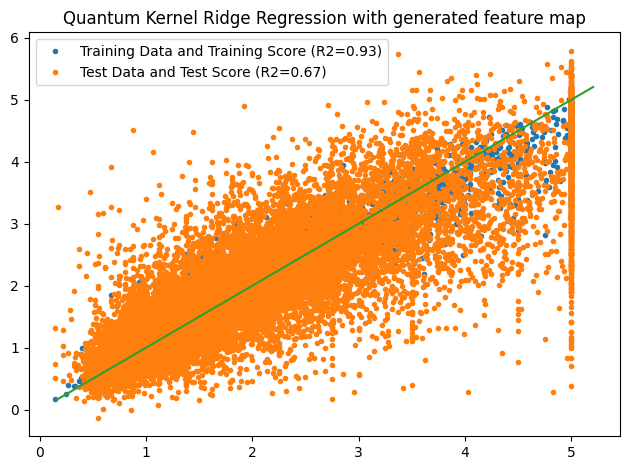

In [23]:

lfm = LayeredFeatureMap.from_string('Rz(x;=(x),{x})-Ry(p,x;=y*(x),{y,x})-Ry(x;=(x),{x})-Ry(p,x;=y*(x),{y,x})-Ry(p,x;=y*(x),{y,x})',num_qubits=8,num_features=8)
np.random.seed(42)
param_ini = np.random.uniform(-1,1,lfm.num_parameters)
quantum_kernel = ProjectedQuantumKernel(lfm,Executor("statevector_simulator"),initial_parameters=param_ini, gamma=0.5)
q_krr = QKRR(quantum_kernel=quantum_kernel, alpha=0.1)
q_krr.fit(X_train,y_train)

Y1_qml = q_krr.predict(X_train)
Y2_qml = q_krr.predict(X_test)

training_score_qml = q_krr.score(X_train,y_train)
test_score_qml = q_krr.score(X_test,y_test)
print("TRAINING SCORE AT START:",q_krr.score(X_train,y_train))
print("TEST SCORE AT START:",q_krr.score(X_test,y_test))
plt.figure()
plt.title("Quantum Kernel Ridge Regression with generated feature map")
plt.plot(y_train,Y1_qml,'.', label=f"Training Data and Training Score (R2={training_score_qml:.2f})")
plt.plot(y_test,Y2_qml,'.', label=f"Test Data and Test Score (R2={test_score_qml:.2f})")
plt.plot([np.min(Y1_qml),np.max(Y1_qml)],[np.min(Y1_qml),np.max(Y1_qml)])
plt.legend(loc="upper left")
plt.tight_layout()

TRAINING SCORE AT START: 0.941390408675362
TEST SCORE AT START: 0.7076068939896693


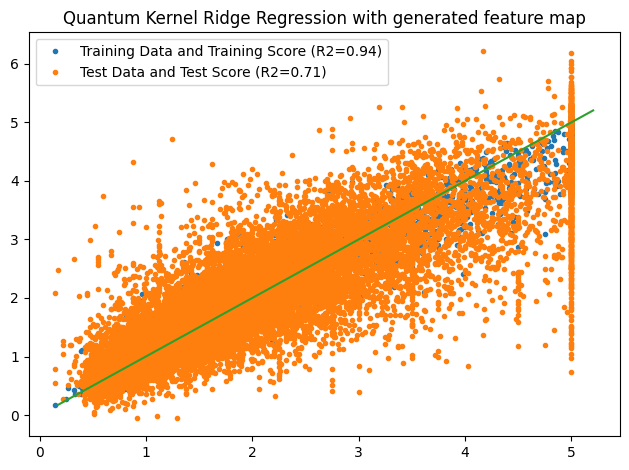

In [25]:
lfm = LayeredFeatureMap.from_string('H-Y-Rz(p,x;=y*(x),{y,x})-Rx(p,x;=y*np.cos(x),{y,x})',num_qubits=8,num_features=8)
np.random.seed(42)
param_ini = np.random.uniform(-1,1,lfm.num_parameters)
quantum_kernel = ProjectedQuantumKernel(lfm,Executor("statevector_simulator"),initial_parameters=param_ini, gamma=0.5)
q_krr = QKRR(quantum_kernel=quantum_kernel, alpha=0.1)
q_krr.fit(X_train,y_train)

Y1_qml = q_krr.predict(X_train)
Y2_qml = q_krr.predict(X_test)

training_score_qml = q_krr.score(X_train,y_train)
test_score_qml = q_krr.score(X_test,y_test)
print("TRAINING SCORE AT START:",q_krr.score(X_train,y_train))
print("TEST SCORE AT START:",q_krr.score(X_test,y_test))
plt.figure()
plt.title("Quantum Kernel Ridge Regression with generated feature map")
plt.plot(y_train,Y1_qml,'.', label=f"Training Data and Training Score (R2={training_score_qml:.2f})")
plt.plot(y_test,Y2_qml,'.', label=f"Test Data and Test Score (R2={test_score_qml:.2f})")
plt.plot([np.min(Y1_qml),np.max(Y1_qml)],[np.min(Y1_qml),np.max(Y1_qml)])
plt.legend(loc="upper left")
plt.tight_layout()

In [34]:
# Define the desired number of data points
desired_num_samples = 400  # Adjust this as needed

# Randomly sample data points
# set the seed to ensure reproducibility
np.random.seed(42)
random_indices = np.random.choice(len(X), desired_num_samples, replace=False)
X_subset = X[random_indices]
y_subset = y[random_indices]


In [36]:
# split into train and test
X_train_subset, X_test_subset, y_train_subset, y_test_subset = train_test_split(X_subset, y_subset, test_size=0.5, random_state=42)

In [37]:
X_train_subset.shape

(200, 8)

In [44]:
X_train_subset

array([[   4.6328    ,   30.        ,    5.06476684, ...,    2.5880829 ,
          37.35      , -121.97      ],
       [   5.5138    ,    7.        ,    6.9498645 , ...,    3.82655827,
          38.15      , -122.22      ],
       [   2.9432    ,   49.        ,    6.02931596, ...,    2.76547231,
          38.1       , -122.24      ],
       ...,
       [  15.0001    ,   32.        ,    8.84504132, ...,    2.7231405 ,
          37.44      , -122.22      ],
       [  11.3074    ,   42.        ,    8.36336336, ...,    2.5015015 ,
          32.82      , -117.31      ],
       [   4.425     ,   26.        ,    5.12313433, ...,    2.26865672,
          32.85      , -117.27      ]])

In [38]:
from xgboost import XGBRegressor

# define model
model = XGBRegressor()

# define search space
param_grid = dict()
param_grid['n_estimators'] = [100, 500, 1000]
param_grid['max_depth'] = [3, 7, 9]
param_grid['learning_rate'] = [0.01, 0.1, 0.2]
param_grid['gamma'] = [0, 0.1, 0.5]
param_grid['reg_alpha'] = [0, 0.1, 1]
param_grid['reg_lambda'] = [0, 0.1, 1]

# define search
search = RandomizedSearchCV(model, param_grid, n_iter=100, scoring='neg_mean_squared_error', n_jobs=-1, cv=5, random_state=42)

# execute search
result = search.fit(X_train_subset, y_train_subset)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)
print('Best Model: %s' % result.best_estimator_)
print('Best Model Score: %s' % result.best_estimator_.score(X_test_subset, y_test_subset))


Best Score: -0.4456620573826221
Best Hyperparameters: {'reg_lambda': 0, 'reg_alpha': 0.1, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0}
Best Model: XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=3, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)
Best Model Score: 0.6660155156397418


TRAINING SCORE AT START: 0.9712495864155737
TEST SCORE AT START: 0.6660155156397418
TRAINING MSE AT START: 0.03506362621826634
TEST MSE AT START: 0.47976479367283775


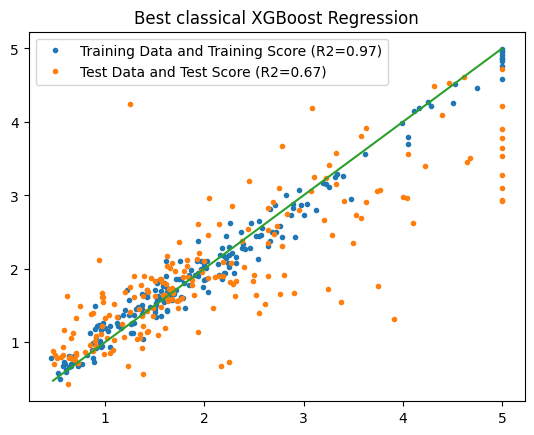

In [39]:
# perform best xgboost regression
xgb = result.best_estimator_
Y1 = xgb.predict(X_train_subset)
Y2 = xgb.predict(X_test_subset)
training_score = xgb.score(X_train_subset,y_train_subset)
test_score = xgb.score(X_test_subset,y_test_subset)
print("TRAINING SCORE AT START:",training_score)
print("TEST SCORE AT START:",test_score)
print("TRAINING MSE AT START:",mean_squared_error(y_train_subset,Y1))
print("TEST MSE AT START:",mean_squared_error(y_test_subset,Y2))
plt.figure()
plt.title("Best classical XGBoost Regression")
plt.plot(y_train_subset,Y1,'.', label=f"Training Data and Training Score (R2={training_score:.2f})")
plt.plot(y_test_subset,Y2,'.', label=f"Test Data and Test Score (R2={test_score:.2f})")
plt.plot([np.min(y_test_subset),np.max(y_test_subset)],[np.min(y_test_subset),np.max(y_test_subset)])
plt.legend(loc="upper left")


TRAINING SCORE AT START: 0.9999972730992691
TEST SCORE AT START: 0.13722834955793473


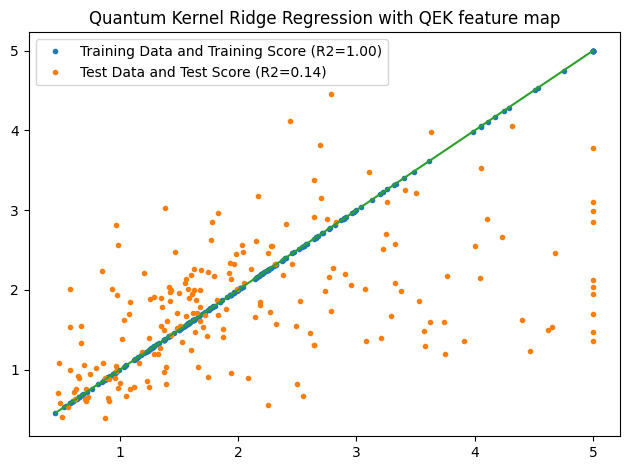

In [43]:
qek_kernel_sub = ProjectedQuantumKernel(qek_map,Executor("statevector_simulator"),parameter_seed=0, gamma=0.5)
qek_krr_sub = QKRR(quantum_kernel=qek_kernel_sub, alpha=0.001)
qek_krr_sub.fit(X_train_subset,y_train_subset)

Y1_qek = qek_krr_sub.predict(X_train_subset)
Y2_qek = qek_krr_sub.predict(X_test_subset)

training_score_qek = qek_krr_sub.score(X_train_subset,y_train_subset)
test_score_qek = qek_krr_sub.score(X_test_subset,y_test_subset)
print("TRAINING SCORE AT START:",qek_krr_sub.score(X_train_subset,y_train_subset))
print("TEST SCORE AT START:",qek_krr_sub.score(X_test_subset,y_test_subset))
plt.figure()
plt.title("Quantum Kernel Ridge Regression with QEK feature map")
plt.plot(y_train_subset,Y1_qek,'.', label=f"Training Data and Training Score (R2={training_score_qek:.2f})")
plt.plot(y_test_subset,Y2_qek,'.', label=f"Test Data and Test Score (R2={test_score_qek:.2f})")
plt.plot([np.min(Y1_qek),np.max(Y1_qek)],[np.min(Y1_qek),np.max(Y1_qek)])
plt.legend(loc="upper left")
plt.tight_layout()


TRAINING SCORE AT START: 0.98148209416557
TEST SCORE AT START: 0.18225313349066408


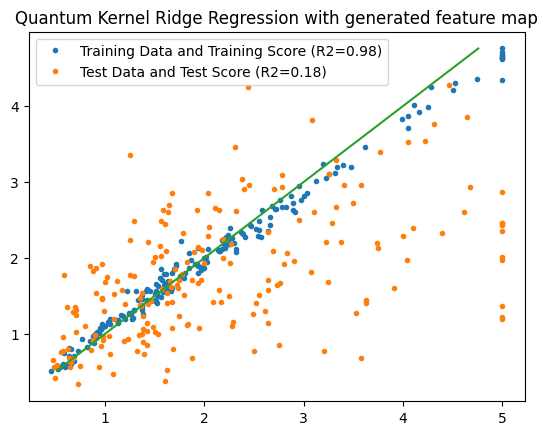

In [48]:
#Rz(x;=(x),{x})-Ry(p,x;=y*(x),{y,x})-Ry(p,x;=y*(x),{y,x})-cx-Rx(p,x;=y*np.cos(x),{y,x})-Y-Rz(p,x;=y*(x),{y,x})


lfm_subset = LayeredFeatureMap.from_string('Rx(p,x;=y*np.cos(x),{y,x})-Ry(p,x;=y*(x),{y,x})-cx-Ry(p,x;=y*(x),{y,x})',num_qubits=8,num_features=8)
param_ini_subset = np.random.uniform(-1,1,lfm_subset.num_parameters)
quantum_kernel_subset = ProjectedQuantumKernel(lfm_subset,Executor("statevector_simulator"),initial_parameters=param_ini_subset, gamma=1.0)
q_krr_subset = QKRR(quantum_kernel=quantum_kernel_subset, alpha=0.1)

q_krr_subset.fit(X_train_subset,y_train_subset)

Y1_qml = q_krr_subset.predict(X_train_subset)
Y2_qml = q_krr_subset.predict(X_test_subset)

training_score_qml = q_krr_subset.score(X_train_subset,y_train_subset)
test_score_qml = q_krr_subset.score(X_test_subset,y_test_subset)
print("TRAINING SCORE AT START:",q_krr_subset.score(X_train_subset,y_train_subset))
print("TEST SCORE AT START:",q_krr_subset.score(X_test_subset,y_test_subset))
plt.figure()
plt.title("Quantum Kernel Ridge Regression with generated feature map")
plt.plot(y_train_subset,Y1_qml,'.', label=f"Training Data and Training Score (R2={training_score_qml:.2f})")
plt.plot(y_test_subset,Y2_qml,'.', label=f"Test Data and Test Score (R2={test_score_qml:.2f})")
plt.plot([np.min(Y1_qml),np.max(Y1_qml)],[np.min(Y1_qml),np.max(Y1_qml)])
plt.legend(loc="upper left")
